In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
class q:
    def __init__(self, w = 0, x = 0, y = 0, z = 0):
        self.w = w
        self.x = x
        self.y = y
        self.z = z
        
    def __repr__(self):
        return "<type:q w:{} x:{} y:{} z:{}>".format(self.w, self.x, self.y, self.z)
    
    def __str__(self):
        return "({}, {}, {}, {})".format(self.w, self.x, self.y, self.z)

    def from_vec(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def from_array(self, v):
        (self.x, self.y, self.z) = v
        
    def ham(self, q1):
        return q(-q1.x * self.x - q1.y * self.y - q1.z * self.z + q1.w * self.w,
                     q1.x * self.w + q1.y * self.z - q1.z * self.y + q1.w * self.x,
                     -q1.x * self.z + q1.y * self.w + q1.z * self.x + q1.w * self.y,
                     q1.x * self.y - q1.y * self.x + q1.z * self.w + q1.w * self.z)
    
    def conj(self):
        return q(self.w, -self.x, -self.y, -self.z)
    
    def vec(self):
        return np.array([self.x, self.y, self.z])
            

In [3]:
class rot(q):
    def __init__(self, ang, vector):
        # Angle ang in radians
        w = np.cos(ang/2)
        s2 = np.sin(ang/2)
        (x, y, z) = s2*np.array(vector)
        super().__init__(w, x, y, z)
        
    def rotate(self, q1):
        q2 = q1.ham(self.conj())
        return self.ham(q2)

In [4]:
r = rot(10*np.pi/180, np.array([1, 0, 0]))
ve = q()
ve.from_array(np.array([0, 1, 8]))
print(r.rotate(ve))

(0.0, 0.0, 2.373993174347651, 7.704813846430735)


In [5]:
d = np.array([72.27, 73.35, 72.68, 73.11, 74.77, 73.80]) #length of linkage
d_avg = np.average(d)
h = 24 #mm horn length
clock_wise_order = [0,5,2,4,1,3]

# The triangle defined here is rotated 60 degrees with respect
# to the wooden base of the platform, motors 3 and 0 are
# located at the top which is opposite the cable harness
adjacent_distance = 34.71 #mm
pair_distance = 112.96 #mm
base_side_length = pair_distance + 2*adjacent_distance

triangle_height = np.sqrt(3)*base_side_length/2
com = triangle_height/3
small_triangle_height = np.sqrt(3)*adjacent_distance/2

b = np.zeros((6,3))

# Matrix to flip vectors across x axis
flip_x = np.diag(np.array([-1,1,1]))

# 120 degree rotation matrix
rotation = np.zeros((3,3))
c, s = np.cos(-2*np.pi/3), np.sin(-2*np.pi/3)
rotation[0,0] = c
rotation[1,0] = s
rotation[0,1] = -s
rotation[1,1] = c
rotation[2,2] = 1

# Prototype vector
b[0] = np.array([adjacent_distance/2, 2*com-small_triangle_height, 0])

# Motors 2 and 1 are a 120 degree rotations of motor 0
b[2] = np.dot(rotation, b[0])
b[1] = np.dot(rotation, b[2])

# Motors 3,4, and 5 are the flipped versions of motors 0, 2, and 1 respectively
b[3] = np.dot(flip_x, b[0])
b[4] = np.dot(flip_x, b[2])
b[5] = np.dot(flip_x, b[1])

# Platform lengths
hex_length = 68.02 + (10.8)*2/np.sqrt(3) # side length of the hexagon, plus modified distance to anchors
bolt_spacing = 19.7 # distance between bolts
hex_triangle_height = np.sqrt(3)*hex_length/2

p = np.zeros((6,3))
p[0] = np.array([bolt_spacing/2,hex_triangle_height, 0])

# Anchors 2 and 1 are a 120 degree rotations of motor 0
p[2] = np.dot(rotation, p[0])
p[1] = np.dot(rotation, p[2])

# Anchors 3,4, and 5 are the flipped versions of motors 0, 2, and 1 respectively
p[3] = np.dot(flip_x, p[0])
p[4] = np.dot(flip_x, p[2])
p[5] = np.dot(flip_x, p[1])


# p[3] = np.array([-bolt_spacing/2,hex_triangle_height, 0])

# # bottom two motors
# length_along_side = (hex_length - bolt_spacing)/2
# height_of_24 = np.sqrt(3)*length_along_side/2
# p[2] = np.array([hex_length/2 + length_along_side/2, -hex_triangle_height + height_of_24, 0])
# p[4] = np.array([-hex_length/2 - length_along_side/2, -hex_triangle_height + height_of_24, 0])

# middle two motors

# b[5] = np.array([, 0])
# b[1] = np.array([, 0])


beta = np.array([180-180, 300-180, 60-180, 180, 300, 60], dtype = np.float)
beta *= np.pi/180

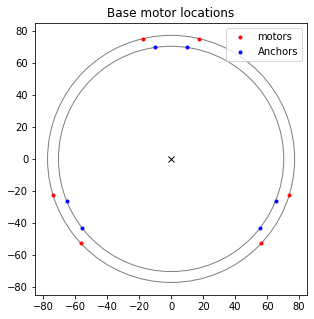

In [6]:
fig, ax = plt.subplots(1,1, figsize= (5,5))
circ = plt.Circle((0, 0), np.linalg.norm(b[0],2), color='k', fill = False, alpha = 0.5)
ax.add_patch(circ)
ax.plot(b[:,0], b[:,1], 'r.', label = "motors")
ax.set_aspect('equal')
ax.set_title('Base motor locations')

circ = plt.Circle((0, 0), np.linalg.norm(p[0],2), color='k', fill = False, alpha = 0.5)
ax.add_patch(circ)
ax.plot(p[:,0], p[:,1], 'b.', label = "Anchors")
ax.set_aspect('equal')
# ax[0].set_title('Platform anchor locations')

ax.plot([0], [0], 'x', color = 'k')
ax.legend()
plt.show()

In [7]:
R = rot(5*np.pi/180, np.array([1, 0, 0]))
z0 = np.sqrt(d_avg**2 + h**2 - (p[:,0] - b[:,0])**2 - (p[:,1] - b[:,1])**2)
T = np.array([0, 0, np.average(z0)])


In [8]:
beta

array([ 0.        ,  2.0943951 , -2.0943951 ,  3.14159265,  5.23598776,
        1.04719755])

In [9]:
l = np.zeros((6,3))
a = np.zeros(6)
e = np.zeros(6)
f = np.zeros(6)
g = np.zeros(6)
p_rot = np.zeros((6,3))
p_quat = np.empty(6, dtype = q)

for i in range(6):
    # Generate quaternion from anchor locations
    p_quat[i] = q()
    p_quat[i].from_array(p[i])
    
    # Rotate anchor location by R
    p_rot[i] = R.rotate(p_quat[i]).vec()

# print(p == p_rot)
l = np.outer(T, np.ones(6)).T + p_rot - b
# print(p_rot, l)
e = 2*h*l[:,2]
f = 2*h*(np.cos(beta)*l[:,0] + np.sin(beta)*l[:,1])
g = np.linalg.norm(l, 2, axis = 1)**2 - (d_avg**2 - h**2)
a = np.arcsin(g/np.sqrt(e**2 + f**2)) - np.arctan2(f,e)
print("rad: ", a)
print("deg: ", a*180/np.pi)
print("PWM: ", a*900/0.3905)

rad:  [0.18285771 0.50145452 0.56299063 0.18285771 0.56299063 0.50145452]
deg:  [10.47697526 28.73122783 32.25698695 10.47697526 32.25698695 28.73122783]
PWM:  [ 421.43903346 1155.72105371 1297.54562373  421.43903346 1297.54562373
 1155.72105371]


In [10]:
np.cos(beta), np.sin(beta)

(array([ 1. , -0.5, -0.5, -1. ,  0.5,  0.5]),
 array([ 0.00000000e+00,  8.66025404e-01, -8.66025404e-01,  1.22464680e-16,
        -8.66025404e-01,  8.66025404e-01]))

In [11]:
(np.cos(beta)*l[:,0] + np.sin(beta)*l[:,1])

array([-7.505     , -7.41825229, -7.64797104, -7.505     , -7.64797104,
       -7.41825229])

In [12]:
(l + b)[:,0:2] == p[:,0:2]

array([[ True, False],
       [False, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False, False]])

In [13]:
np.array([np.cos(beta), np.sin(beta)])*h

array([[ 2.40000000e+01, -1.20000000e+01, -1.20000000e+01,
        -2.40000000e+01,  1.20000000e+01,  1.20000000e+01],
       [ 0.00000000e+00,  2.07846097e+01, -2.07846097e+01,
         2.93915232e-15, -2.07846097e+01,  2.07846097e+01]])

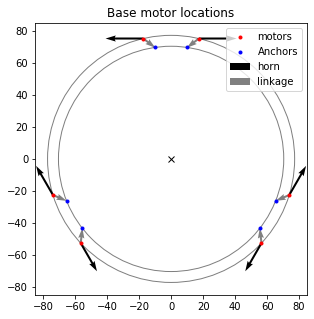

In [14]:
fig, ax = plt.subplots(1,1, figsize= (5,5))
circ = plt.Circle((0, 0), np.linalg.norm(b[0],2), color='k', fill = False, alpha = 0.5)
ax.add_patch(circ)
ax.plot(b[:,0], b[:,1], 'r.', label = "motors")
ax.set_aspect('equal')
ax.set_title('Base motor locations')

circ = plt.Circle((0, 0), np.linalg.norm(p[0],2), color='k', fill = False, alpha = 0.5)
ax.add_patch(circ)
ax.plot(p[:,0], p[:,1], 'b.', label = "Anchors")
ax.set_aspect('equal')
# ax[0].set_title('Platform anchor locations')

ax.quiver(b[:,0], b[:,1], h*np.cos(a)*np.cos(beta), h*np.cos(a)*np.sin(beta), angles='xy', scale_units='xy', scale = 1, label = "horn")
ax.quiver(b[:,0], b[:,1], l[:,0], l[:,1], color = ["grey"]*6, angles='xy', scale_units='xy', scale = 1, label = "linkage")
# ax.quiver(b[:,0] + h*np.cos(beta), b[:,1] + h*np.sin(beta), l[:,0], l[:,1], color = ["grey"]*6, angles='xy', scale_units='xy', scale = 1)

ax.plot([0], [0], 'x', color = 'k')
ax.legend()
plt.show()

In [15]:
np.array([b[:,0],b[:,1]])

array([[ 17.355     , -73.835     ,  56.48      , -17.355     ,
        -56.48      ,  73.835     ],
       [ 75.23740033, -22.58882928, -52.64857105,  75.23740033,
        -52.64857105, -22.58882928]])

In [16]:
b[:,0:2]

array([[ 17.355     ,  75.23740033],
       [-73.835     , -22.58882928],
       [ 56.48      , -52.64857105],
       [-17.355     ,  75.23740033],
       [-56.48      , -52.64857105],
       [ 73.835     , -22.58882928]])